In [23]:
import pandas as pd
import numpy as np
from cmdstanpy import CmdStanModel
from sklearn.metrics import  roc_curve, auc ,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(color_codes = True)

In [24]:
pima = pd.read_csv('Data/diabetes.csv', sep=';')
df = pd.read_csv('Data/diabetes_pt1.csv', sep=';')
df_test = pd.read_csv('Data/diabetes_pt2.csv', sep=';')

In [25]:
feature_columns = ['Glucose', 'Age', 'BMI', 'BloodPressure', 'Insulin', 'DiabetesPedigreeFunction']

stan2_data = {
    'N': len(df),
    'X': df[feature_columns].values,
    'y': df['Outcome'].values
}

test2_data = {
    'N': len(df_test),
    'X': df_test[feature_columns].values,
    'y': df_test['Outcome'].values
}

In [26]:
sm2 = CmdStanModel(stan_file='Stan/code_2.stan')

fit2 = sm2.sample(data=stan2_data, iter_sampling=2000, chains=4, iter_warmup=1000)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▋         | 00:00 Iteration:    1 / 3000 [  0%]  (Warmup)

chain 1 |▉         | 00:01 Iteration:  100 / 3000 [  3%]  (Warmup)

chain 1 |█▎        | 00:01 Iteration:  200 / 3000 [  6%]  (Warmup)

chain 1 |█▌        | 00:01 Iteration:  300 / 3000 [ 10%]  (Warmup)

chain 1 |██▏       | 00:01 Iteration:  500 / 3000 [ 16%]  (Warmup)

chain 1 |██▌       | 00:02 Iteration:  600 / 3000 [ 20%]  (Warmup)

chain 1 |██▊       | 00:02 Iteration:  700 / 3000 [ 23%]  (Warmup)

chain 1 |███▏      | 00:02 Iteration:  800 / 3000 [ 26%]  (Warmup)



chain 1 |███▍      | 00:02 Iteration:  900 / 3000 [ 30%]  (Warmup)

chain 1 |████      | 00:02 Iteration: 1001 / 3000 [ 33%]  (Sampling)

chain 1 |████▍     | 00:02 Iteration: 1100 / 3000 [ 36%]  (Sampling)

chain 1 |████▋     | 00:03 Iteration: 1200 / 3000 [ 40%]  (Sampling)

chain 1 |█████     | 00:03 Iteration: 1300 / 3


INFO:cmdstanpy:CmdStan done processing.


In [27]:
betas = ['glucose', 'bmi', 'age', 'bp', 'insulin', 'dpf']
df3 = fit2.draws_pd()
alpha_mean = df3['alpha'].mean()
beta_means = [df3[f'beta_{name}'].mean() for name in betas]

In [28]:
logit_preds_test = alpha_mean + np.dot(test2_data['X'], beta_means)
probs_test2 = 1 / (1 + np.exp(-logit_preds_test))
preds_test2 = (probs_test2 > 0.5).astype(int)

probs_df = pd.DataFrame(probs_test2, columns=['Probability'])
print(probs_df.head())

   Probability
0     0.153552
1     0.289066
2     0.534758
3     0.330227
4     0.197739


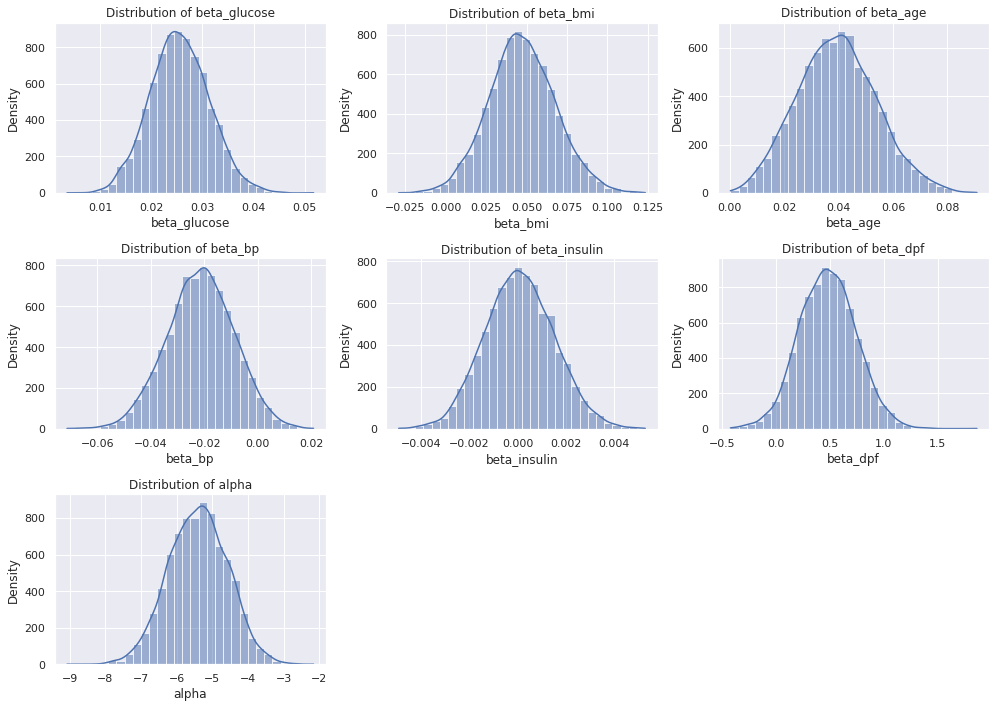

             alpha  beta_glucose     beta_bmi     beta_age      beta_bp  \
count  8000.000000   8000.000000  8000.000000  8000.000000  8000.000000   
mean     -5.401464      0.025553     0.047143     0.039356    -0.021432   
std       0.825006      0.005740     0.020528     0.014545     0.012441   
min      -9.074380      0.003535    -0.029128     0.000175    -0.071358   
25%      -5.967335      0.021660     0.033617     0.029205    -0.029583   
50%      -5.388255      0.025423     0.046679     0.039158    -0.021261   
75%      -4.832387      0.029402     0.060652     0.049092    -0.012943   
max      -2.159950      0.051724     0.123407     0.090920     0.020835   

       beta_insulin     beta_dpf  
count   8000.000000  8000.000000  
mean       0.000086     0.478343  
std        0.001427     0.263061  
min       -0.004921    -0.424064  
25%       -0.000877     0.297196  
50%        0.000063     0.476955  
75%        0.001047     0.655046  
max        0.005290     1.862770  


In [29]:
plt.figure(figsize=(14, 10))
for i, name in enumerate(betas):
    beta_column = f'beta_{name}'
    plt.subplot(3, 3, i+1)
    sns.histplot(df3[beta_column], kde=True, bins=30)
    plt.title(f'Distribution of {beta_column}')
    plt.xlabel(beta_column)
    plt.ylabel('Density')

plt.subplot(3, 3, len(betas)+1)
sns.histplot(df3['alpha'], kde=True, bins=30)
plt.title('Distribution of alpha')
plt.xlabel('alpha')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

summary_stats = df3[['alpha'] + [f'beta_{name}' for name in betas]].describe()
print(summary_stats)

In [30]:
accuracy = accuracy_score(test2_data['y'], preds_test2)
precision = precision_score(test2_data['y'], preds_test2)
recall = recall_score(test2_data['y'], preds_test2)
f1 = f1_score(test2_data['y'], preds_test2)

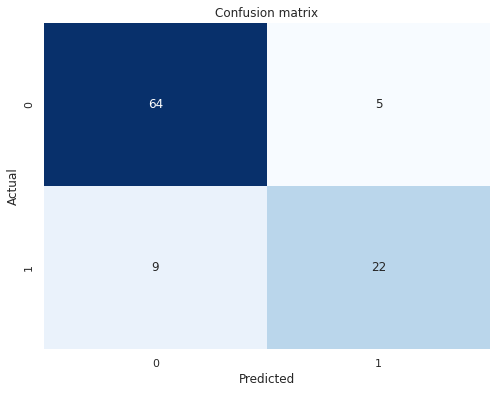

In [31]:

preds_test2 = (probs_test2 > 0.5).astype(int)

conf_matrix = confusion_matrix(test2_data['y'], preds_test2)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [32]:
fpr, tpr, _ = roc_curve(test2_data['y'], probs_test2)
roc_auc = auc(fpr, tpr)
 
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.86
Precision: 0.81
Recall: 0.71
F1 Score: 0.76


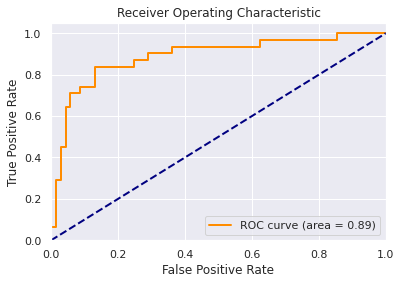

In [33]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()